In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import boxcox
import itertools
import scipy.stats as stats
from itertools import product
from scipy.special import inv_boxcox

Etape 1 : Chargement et visualisation des données brutes

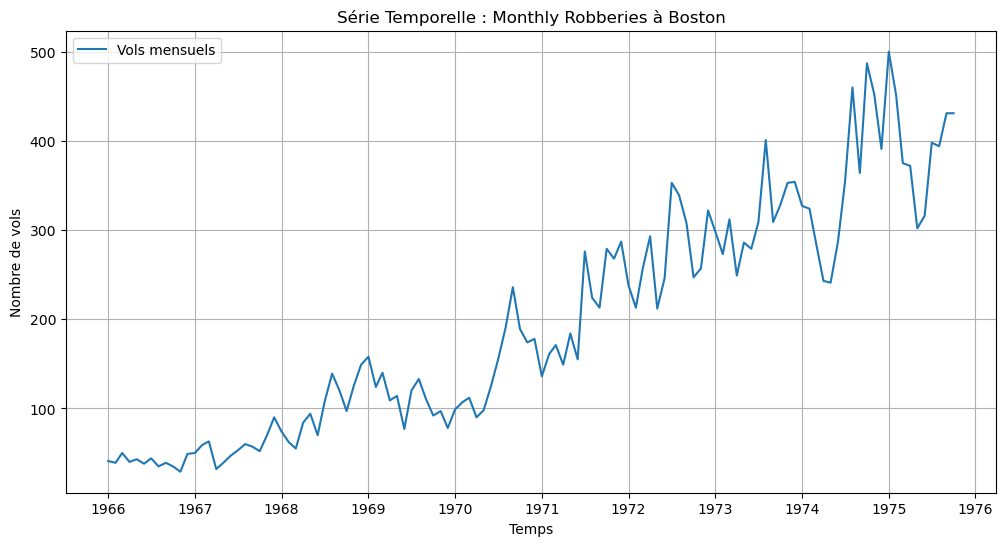

In [3]:
# Chargement des données
data = pd.read_csv("monthly-robberies.csv", parse_dates=["Month"], index_col="Month")
data = data.sort_index()

# Visualisation des données brutes
plt.figure(figsize=(12, 6))
plt.plot(data, label="Vols mensuels")
plt.title("Série Temporelle : Monthly Robberies à Boston")
plt.xlabel("Temps")
plt.ylabel("Nombre de vols")
plt.legend()
plt.grid()
plt.show()


** Les données sont indexées par date, avec une fréquence mensuelle.

** "Robberies" (vols) représente le nombre de vols enregistrés chaque mois.

Interprétation du graphe : Le graphique montre une tendance et une saisonalité peut etre possible !! 

EDA:

In [4]:

# Analyse Descriptive
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118 entries, 1966-01-01 to 1975-10-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Robberies  118 non-null    int64
dtypes: int64(1)
memory usage: 1.8 KB
None
        Robberies
count  118.000000
mean   196.288136
std    128.043602
min     29.000000
25%     85.500000
50%    166.000000
75%    296.750000
max    500.000000


Interprétation de l'analyse statistique :

1- Nombre total d'observations : 118 valeurs, sans valeurs manquantes.

2- Moyenne : En moyenne, environ 196,3 vols sont enregistrés chaque mois.

3- Écart-type (std) : L’écart-type est de 128,0, indiquant une forte variabilité dans le nombre de vols d’un mois à l’autre.

4- Minimum : Le nombre minimum de vols enregistrés en un mois est 29.

5- 25e centile (Q1) : 25 % des mois ont enregistré moins de 85,5 vols.

6- Médiane (50e centile) : 50 % des mois ont enregistré moins de 166 vols.

7- 75e centile (Q3) : 75 % des mois ont enregistré moins de 296,75 vols, ce qui signifie que seuls 25 % des mois ont dépassé ce seuil.

8- Maximum : Le nombre maximal de vols enregistrés en un mois est de 500.

Conclusion : 

- Le nombre de vols mensuels varie fortement, allant de 29 à 500.

- L’écart-type élevé (128,0) montre que le nombre de vols change considérablement d’un mois à l’autre, peut-être en raison de facteurs externes.


In [5]:

# Vérifier les valeurs nulles
print(data.isnull().sum())



Robberies    0
dtype: int64


Effectivement pas de valeurs manquantes !!

Etape 2 : Feature Engineering

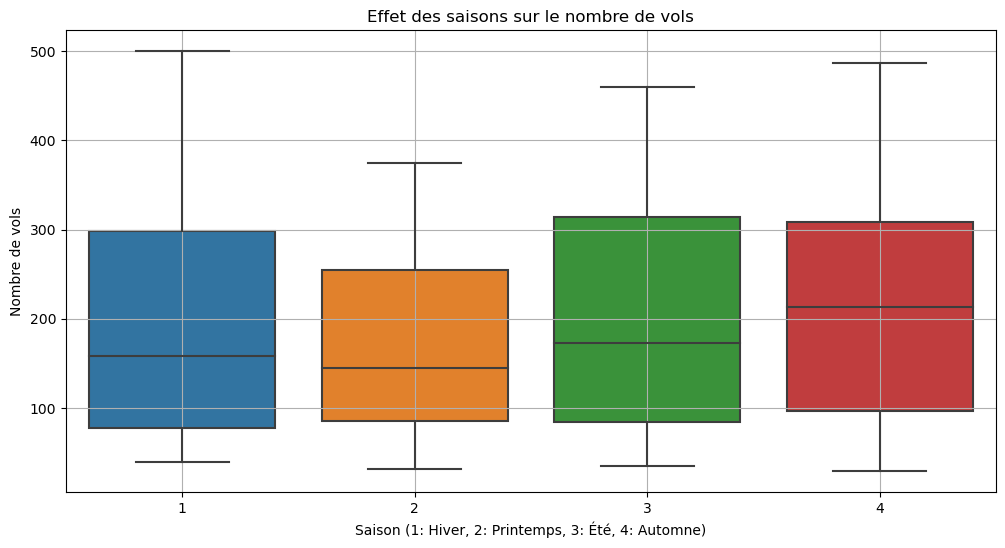

In [6]:
# Ajouter des variables temporelles
data['Year'] = data.index.year

# Ajouter une colonne pour les saisons 
data['Season'] = data.index.month.map(lambda x: (x % 12 + 3) // 3)

# Visualisation des effets saisonniers
plt.figure(figsize=(12, 6))
sns.boxplot(x="Season", y="Robberies", data=data)
plt.title("Effet des saisons sur le nombre de vols")
plt.xlabel("Saison (1: Hiver, 2: Printemps, 3: Été, 4: Automne)")
plt.ylabel("Nombre de vols")
plt.grid()
plt.show()


 Exemple : 
 
 Janvier (x = 1):

 
(1%12+3)//3=(1+3)//3=4//3=1 → Hiver.


Interprétation : 
Il est observable que les vols diminuent en hiver !!

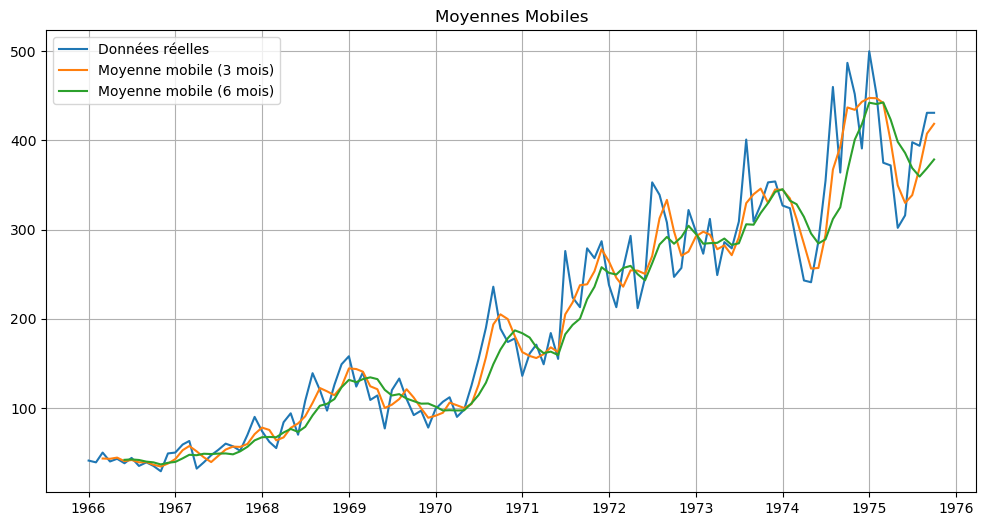

In [7]:
# Ajouter des moyennes mobiles pour lisser les données
data['MA_3'] = data['Robberies'].rolling(window=3).mean()
data['MA_6'] = data['Robberies'].rolling(window=6).mean()

# Visualisation des moyennes mobiles
plt.figure(figsize=(12, 6))
plt.plot(data['Robberies'], label="Données réelles")
plt.plot(data['MA_3'], label="Moyenne mobile (3 mois)")
plt.plot(data['MA_6'], label="Moyenne mobile (6 mois)")
plt.title("Moyennes Mobiles")
plt.legend()
plt.grid()
plt.show()


Les moyennes mobiles révèlent plus les tendances en réduisant le bruit.

Visualisation des données

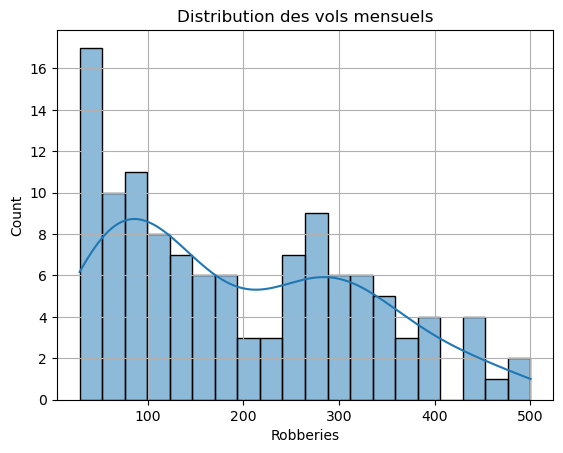

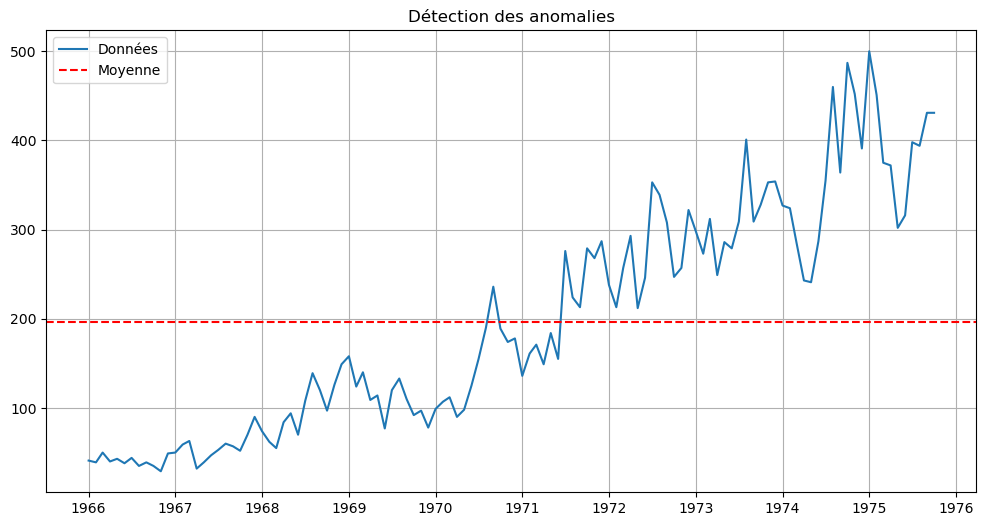

In [8]:
# Visualisation de la distribution
sns.histplot(data['Robberies'], kde=True, bins=20)
plt.title("Distribution des vols mensuels")
plt.grid()
plt.show()

# Détection des anomalies
plt.figure(figsize=(12, 6))
plt.plot(data['Robberies'], label="Données")
plt.axhline(y=data['Robberies'].mean(), color='r', linestyle='--', label="Moyenne")
plt.title("Détection des anomalies")
plt.legend()
plt.grid()
plt.show()


La distribution ne suit une loi normale.

La moyenne et la variance ne sont pas fixes

In [9]:
data.head(5)

,Robberies,Year,Season,MA_3,MA_6
Month,,,,,
1966-01-01,41,1966,1,NaN,NaN
1966-02-01,39,1966,1,NaN,NaN
1966-03-01,50,1966,2,43.333333,NaN
1966-04-01,40,1966,2,43.000000,NaN
1966-05-01,43,1966,2,44.333333,NaN


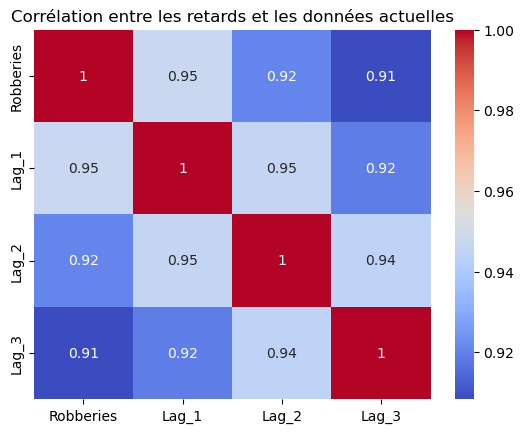

In [10]:
# Ajouter des retards (lags)
data['Lag_1'] = data['Robberies'].shift(1)
data['Lag_2'] = data['Robberies'].shift(2)
data['Lag_3'] = data['Robberies'].shift(3)

# Visualisation de la corrélation avec les retards
sns.heatmap(data[['Robberies', 'Lag_1', 'Lag_2', 'Lag_3']].corr(), annot=True, cmap='coolwarm')
plt.title("Corrélation entre les retards et les données actuelles")
plt.show()



Les fortes corrélations avec les lags suggèrent une structure autorégressive.

In [11]:
data.head(5)

,Robberies,Year,Season,MA_3,MA_6,Lag_1,Lag_2,Lag_3
Month,,,,,,,,
1966-01-01,41,1966,1,NaN,NaN,NaN,NaN,NaN
1966-02-01,39,1966,1,NaN,NaN,41.0,NaN,NaN
1966-03-01,50,1966,2,43.333333,NaN,39.0,41.0,NaN
1966-04-01,40,1966,2,43.000000,NaN,50.0,39.0,41.0
1966-05-01,43,1966,2,44.333333,NaN,40.0,50.0,39.0


Étape 3 : Test de la stationnarité

In [12]:
# Test ADF (Augmented Dickey-Fuller)
result = adfuller(data['Robberies'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] > 0.05:
    print("La série n'est pas stationnaire.")
else:
    print("La série est déjà stationnaire.")


ADF Statistic: 1.0011021402458138
p-value: 0.9942775638057234
La série n'est pas stationnaire.


Étape 4 : Décomposition de la série temporelle

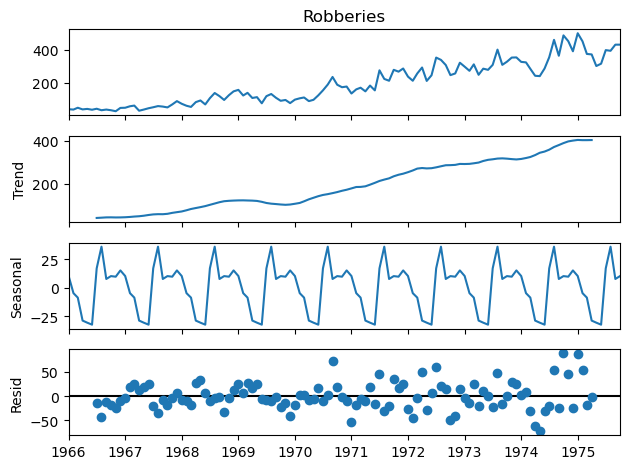

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition additive
decomposition = seasonal_decompose(data['Robberies'], model='additive', period=12)

# Visualisation
decomposition.plot()
plt.show()


Tendance : Changements à long terme.

Saisonnalité : Fluctuations périodiques.

Résidus : Bruit aléatoire.

Étape 5 : Modélisation avec ARIMA


Détermination des paramètres

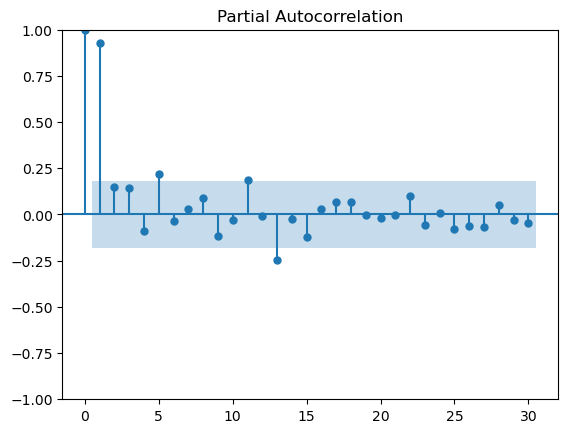

In [14]:
# Tracer le PACF pour déterminer p
plot_pacf(data['Robberies'].dropna(), lags=30)
plt.show()


Les deux premiers lags sont significatifs , on prend p = 2

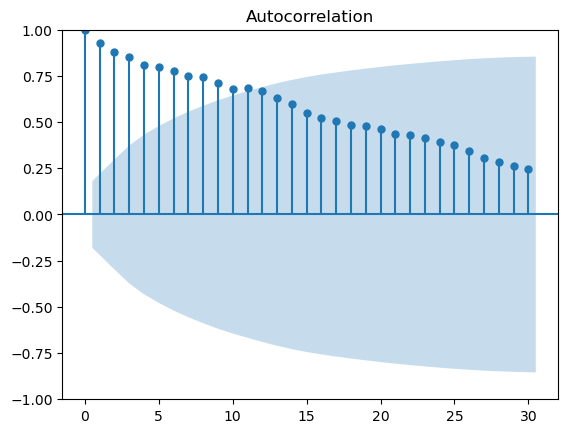

In [15]:
# Tracer l'ACF pour déterminer q
plot_acf(data['Robberies'].dropna(), lags=30)
plt.show()


on prend q est 3 , car la corrélation semble diminuer progressivement après ce lag.

In [16]:
# Appliquer une différenciation et tester la stationnarité
data_diff = data['Robberies'].diff().dropna()
result_diff = adfuller(data_diff)
print('ADF Statistic (après différenciation):', result_diff[0])
print('p-value:', result_diff[1])
if result_diff[1] > 0.05:
    print("La série n'est pas stationnaire.")
else:
    print("La série est stationnaire après différenciation.")


ADF Statistic (après différenciation): -7.428564475067203
p-value: 6.450795412686915e-11
La série est stationnaire après différenciation.


On prend d = 1

c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Robberies   No. Observations:                  118
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -591.486
Date:                Wed, 04 Dec 2024   AIC                           1194.971
Time:                        23:05:53   BIC                           1211.544
Sample:                    01-01-1966   HQIC                          1201.700
                         - 10-01-1975                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6523      0.044    -37.342      0.000      -1.739      -1.566
ar.L2         -0.9272      0.043    -21.678      0.000      -1.011      -0.843
ma.L1          1.4066      0.209      6.745      0.0

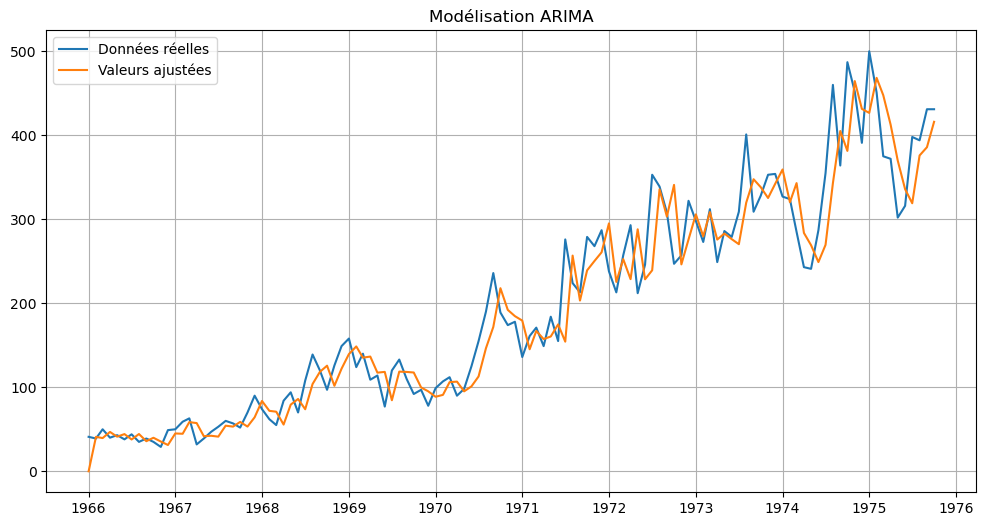

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Définir les paramètres (p, d, q)
p, d, q = 2, 1, 3

# Entraîner le modèle
model = ARIMA(data['Robberies'], order=(p, d, q))
model_fit = model.fit()

# Résumé du modèle
print(model_fit.summary())

# Visualisation des prédictions
plt.figure(figsize=(12, 6))
plt.plot(data['Robberies'], label="Données réelles")
plt.plot(model_fit.fittedvalues, label="Valeurs ajustées")
plt.legend()
plt.title("Modélisation ARIMA")
plt.grid()
plt.show()


Le modèle semble relativement précis, bien que certaines fluctuations importantes des données réelles soient légèrement décalées ou mal ajustées (notamment dans les pics ou les creux les plus extrêmes).

Cela pourrait indiquer un besoin d'améliorer les paramètres ou de considérer des effets externes (non modélisés).

Étape 5 : Validation avec Walking Forward


c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likeliho

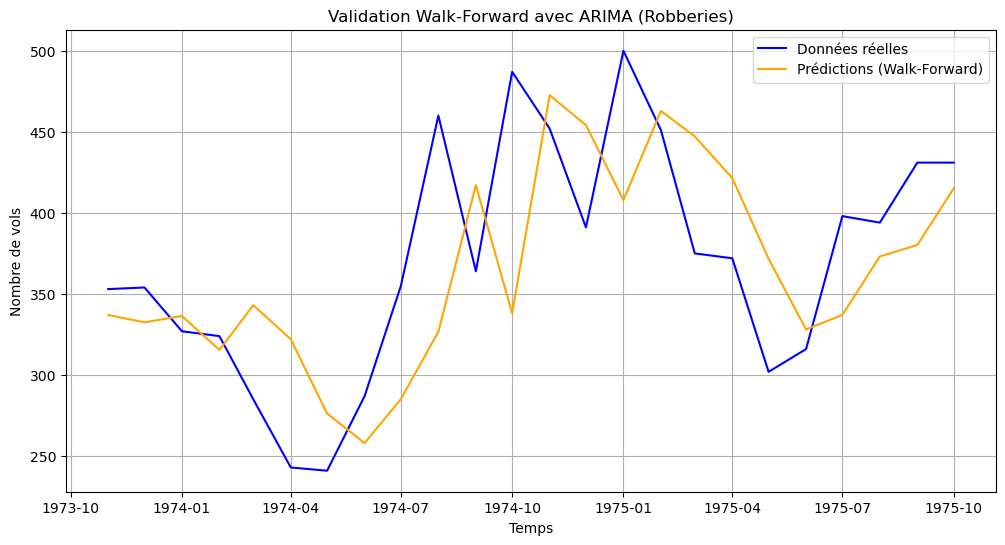

In [18]:

# Diviser les données en entraînement et test
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Validation Walk-Forward
history = list(train['Robberies'].values)  # Liste pour les données historiques
predictions = []


p, d, q = 2, 1, 3  # Exemple basé sur les graphiques PACF et ACF

for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))  # Ajuster le modèle ARIMA
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1)[0]  # Prédiction sur une période
    predictions.append(pred)  # Ajouter la prédiction à la liste
    history.append(test['Robberies'].iloc[t])  # Ajouter la valeur réelle dans l'historique

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Robberies'], label="Données réelles", color="blue")
plt.plot(test.index, predictions, label="Prédictions (Walk-Forward)", color="orange")
plt.legend()
plt.title("Validation Walk-Forward avec ARIMA (Robberies)")
plt.xlabel("Temps")
plt.ylabel("Nombre de vols")
plt.grid()
plt.show()



 - Le modèle capture assez bien les cycles et les tendances générales des données.

- La synchronisation des prédictions avec les données réelles est correcte dans certaines zones.

- Le modèle semble avoir du mal à suivre les fluctuations extrêmes (pics et creux marqués).

- Les prédictions sont souvent décalées par rapport aux données réelles, ce qui pourrait indiquer des limitations dans la capture des variations saisonnières ou des facteurs externes.

Etape 6 : Grid Search


In [19]:
def grid_search_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
        except:
            continue
    return best_cfg, best_score

In [20]:
# Définir les plages pour p, d, q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 5)

best_cfg, best_score = grid_search_arima(train['Robberies'], p_values, d_values, q_values)
print(f"Meilleurs paramètres ARIMA: {best_cfg} avec AIC: {best_score}")

c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

Meilleurs paramètres ARIMA: (2, 1, 3) avec AIC: 910.6863645651058


c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C'est les paramètres qu'on a choisi d'après l'observation des graphes et de la différenciation !

Etape 7 : Evaluation des performances et analyse des résidus

In [23]:
# Calcul des métriques
residuals = test['Robberies'].values - np.array(predictions)
mae = mean_absolute_error(test['Robberies'], predictions)
mse = mean_squared_error(test['Robberies'], predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 50.06065353839987
Mean Squared Error: 3869.652803031666
Root Mean Squared Error: 62.20653344329409


In [24]:
# Modèle de persistance (Baseline)
persistence_predictions = test['Robberies'].shift(1).dropna()
test_persistence = test['Robberies'][1:]
mse_baseline = mean_squared_error(test_persistence, persistence_predictions)
rmse_baseline = np.sqrt(mse_baseline)
print(f"Persistence Model RMSE: {rmse_baseline}")

Persistence Model RMSE: 60.561144093494825


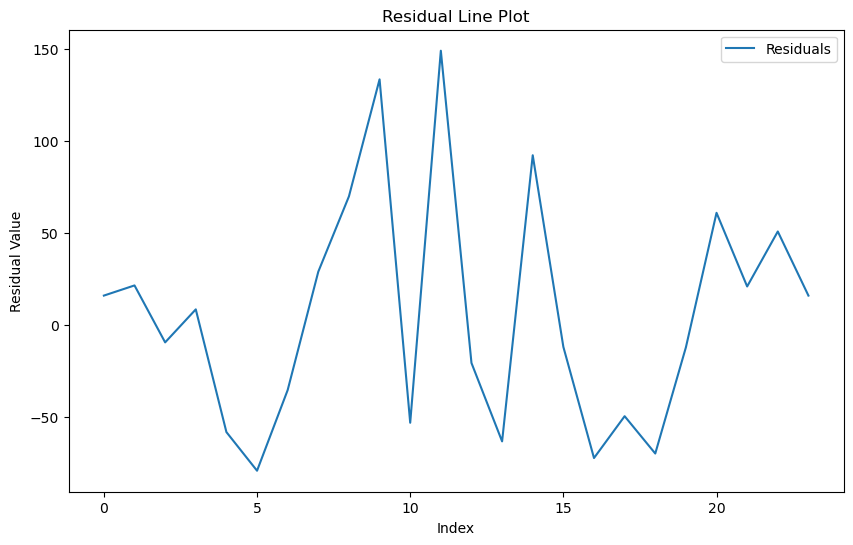

In [25]:
# Visualisation des résidus
plt.figure(figsize=(10, 6))
plt.plot(residuals, label="Residuals")
plt.title("Residual Line Plot")
plt.xlabel("Index")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

In [26]:
# Résumé des statistiques des résidus
print("\nResidual Summary Statistics:")
print(pd.Series(residuals).describe())


Residual Summary Statistics:
count     24.000000
mean       5.568963
std       63.289310
min      -79.051952
25%      -50.353399
50%       -0.453717
75%       34.412006
max      148.840065
dtype: float64


Le modèle est mal ajusté à certaines données (peut-être des points aberrants ou une non-linéarité non capturée).


Les données pourraient nécessiter une transformation ou des caractéristiques supplémentaires pour améliorer les prédictions.

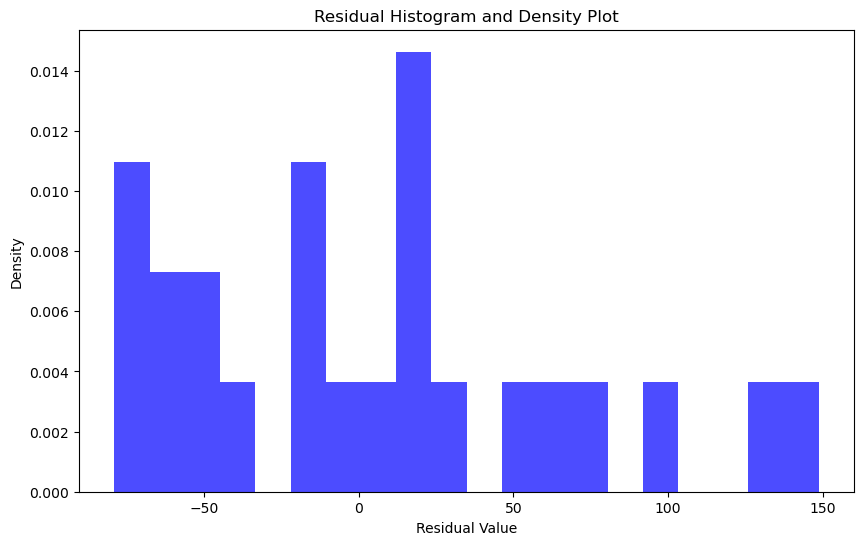

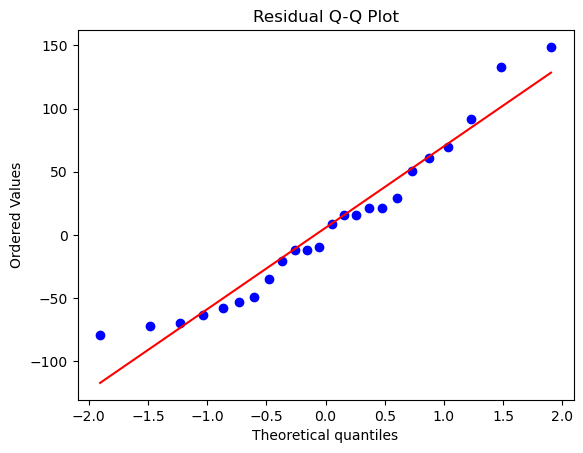

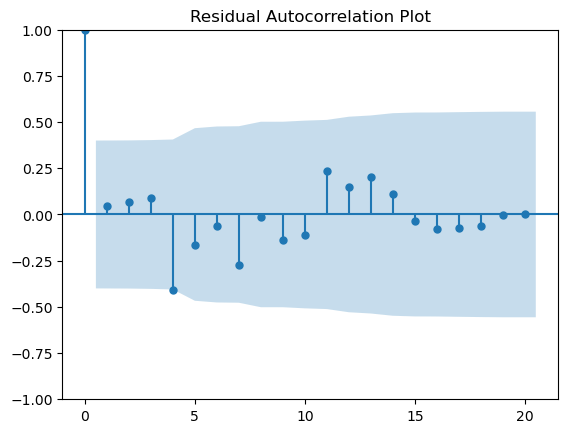

In [27]:
# Histogramme et densité des résidus
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7, color="blue", density=True)
plt.title("Residual Histogram and Density Plot")
plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.show()

# Q-Q Plot des résidus
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Residual Q-Q Plot")
plt.show()

# Autocorrélation des résidus
plot_acf(residuals, lags=20)
plt.title("Residual Autocorrelation Plot")
plt.show()


Histogramme des résidus :

Les résidus ne suivent pas une distribution normale, avec des pics irréguliers et des valeurs extrêmes.

Cela reflète des erreurs importantes sur certaines prédictions.

Diagramme Q-Q :

Les points dévient fortement de la ligne rouge aux extrémités, confirmant la présence de valeurs aberrantes et une non-normalité des résidus.

Amélioration avec transformers : 

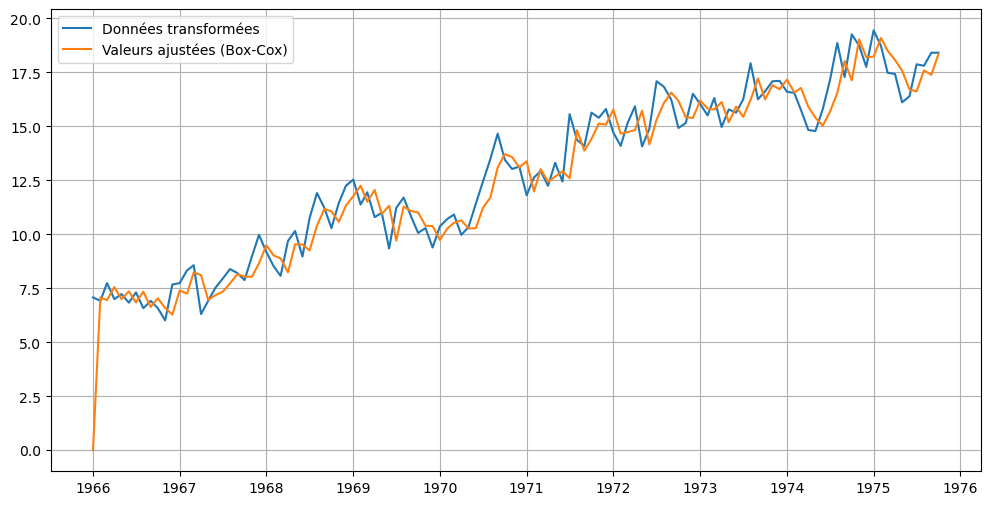

In [30]:
# Transformation Box-Cox
data_transformed, lambda_ = boxcox(data['Robberies'])

# Application du modèle sur données transformées
model = ARIMA(data_transformed, order=(p, d, q))
model_fit_transformed = model.fit()

# Visualisation des ajustements
plt.figure(figsize=(12, 6))
plt.plot(data.index, data_transformed, label="Données transformées")
plt.plot(data.index, model_fit_transformed.fittedvalues, label="Valeurs ajustées (Box-Cox)")
plt.legend()
plt.grid()
plt.show()


On reprend notre méthodogie pour voir si ça améliore notre modèle

In [35]:
#  Paramètres pour la grid search
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
param_combinations = list(product(p_values, d_values, q_values))

In [36]:

#Définir une fonction pour calculer les performances avec ARIMA
def evaluate_arima_model(train, test, order, lambda_):
    history = list(train)
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        predictions.append(yhat)
        history.append(test[t])

    # Calculer les performances
    predictions_inverted = inv_boxcox(predictions, lambda_)
    test_inverted = inv_boxcox(test, lambda_)
    rmse = np.sqrt(mean_squared_error(test_inverted, predictions_inverted))
    mae = mean_absolute_error(test_inverted, predictions_inverted)
    return rmse, mae


In [37]:
#Split test,train data
train_size = int(len(data_transformed) * 0.8)
data_train, data_test = data_transformed[:train_size], data_transformed[train_size:]


In [38]:
best_score, best_cfg = float('inf'), None
best_rmse, best_mae = None, None

for params in param_combinations:
    try:
        rmse, mae = evaluate_arima_model(data_train, data_test, params, lambda_)
        if rmse < best_score:
            best_score, best_cfg = rmse, params
            best_rmse, best_mae = rmse, mae
        print(f'ARIMA{params} - RMSE: {rmse:.4f}, MAE: {mae:.4f}')
    except Exception as e:
        continue

print(f'Best ARIMA{best_cfg} - RMSE: {best_rmse:.4f}, MAE: {best_mae:.4f}')

ARIMA(0, 0, 0) - RMSE: 233.6315, MAE: 223.7713
ARIMA(0, 0, 1) - RMSE: 151.3959, MAE: 139.9577
ARIMA(0, 0, 2) - RMSE: 123.2111, MAE: 103.8582
ARIMA(0, 1, 0) - RMSE: 59.5053, MAE: 46.5417
ARIMA(0, 1, 1) - RMSE: 59.1986, MAE: 48.0564
ARIMA(0, 1, 2) - RMSE: 59.3108, MAE: 46.1196
ARIMA(1, 0, 0) - RMSE: 60.1583, MAE: 46.9270
ARIMA(1, 0, 1) - RMSE: 59.6782, MAE: 47.8084
ARIMA(1, 0, 2) - RMSE: 59.7873, MAE: 46.0368


c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0) - RMSE: 58.3478, MAE: 46.4105
ARIMA(1, 1, 1) - RMSE: 58.6113, MAE: 46.2471
ARIMA(1, 1, 2) - RMSE: 59.8646, MAE: 46.8671
ARIMA(2, 0, 0) - RMSE: 59.1273, MAE: 46.1874


c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: C

ARIMA(2, 0, 1) - RMSE: 59.2308, MAE: 46.6296
ARIMA(2, 0, 2) - RMSE: 60.0655, MAE: 46.4768
ARIMA(2, 1, 0) - RMSE: 59.0870, MAE: 47.4758
ARIMA(2, 1, 1) - RMSE: 60.2894, MAE: 46.8636


c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\E15\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 1, 2) - RMSE: 59.2632, MAE: 46.2457
Best ARIMA(1, 1, 0) - RMSE: 58.3478, MAE: 46.4105


In [39]:
#Ajustement du modèle
final_model = ARIMA(data_train, order=best_cfg)
final_model_fit = final_model.fit()

In [40]:
predictions = final_model_fit.forecast(steps=len(data_test))
predictions_inverted = inv_boxcox(predictions, lambda_)
data_test_inverted = inv_boxcox(data_test, lambda_)

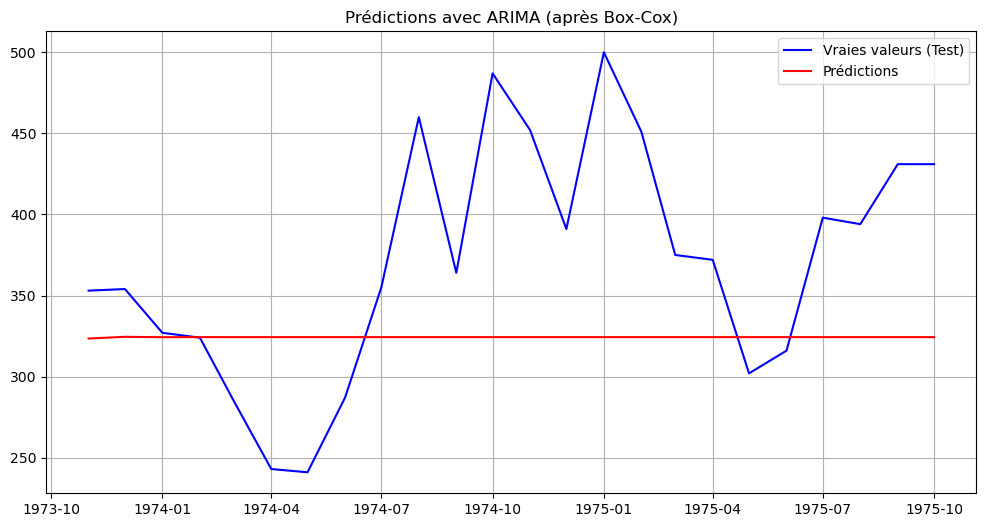

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], data_test_inverted, label='Vraies valeurs (Test)', color='blue')
plt.plot(data.index[train_size:], predictions_inverted, label='Prédictions', color='red')
plt.legend()
plt.grid()
plt.title('Prédictions avec ARIMA (après Box-Cox)')
plt.show()


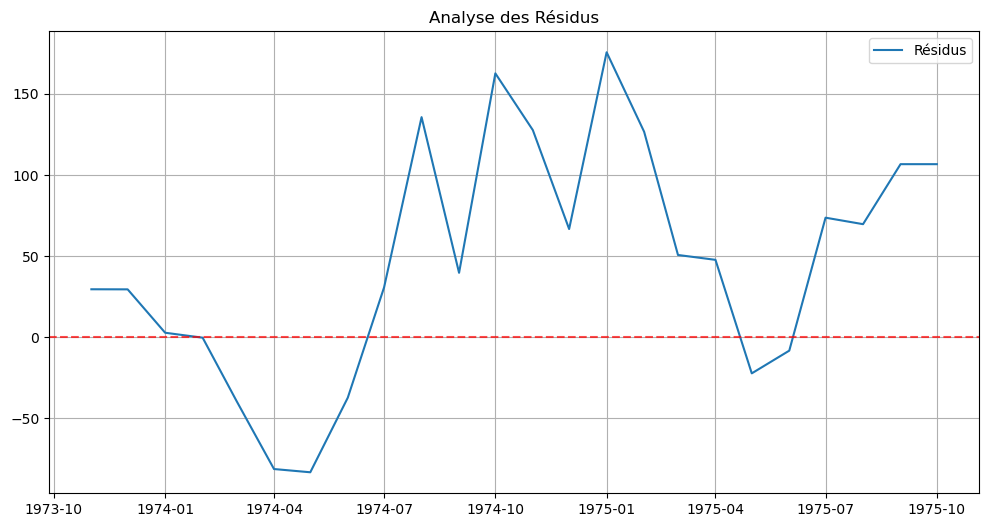

In [42]:
residuals = data_test_inverted - predictions_inverted
plt.figure(figsize=(12, 6))
plt.plot(data.index[train_size:], residuals, label='Résidus')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.grid()
plt.title('Analyse des Résidus')
plt.show()


In [36]:
print(f'Moyenne des résidus: {np.mean(residuals):.4f}')
print(f'Ecart-type des résidus: {np.std(residuals):.4f}')


Moyenne des résidus: 46.2337
Ecart-type des résidus: 70.8308


Le modèle est sous ajusté !! Le box cox n'est pas bon comme transformateur cat  il change l'échelle et ça rend le modèle mal performant ! 